Перед тем, как приступить к построению дашборда, проведем профайлинг данных:
1. Оценка структуры данных: типы полей, наличие пропусков, дубликатов + удаление избыточных полей, которые не будут использоваться в построении дашборда.
2. Исследование распределения метрик. Поскольку исходный датасет синтетический, некоторые закономерности могут выглядеть нереалистично. 
3. Обогащение датасета, определение связей внутри таблицы и ее разделение.

Исходный набор данных:
https://www.kaggle.com/datasets/robertocarlost/fmcg-multi-country-sales-dataset?select=fmcg_sales_3years_1M_rows.csv
Датасет содержит 1.1 млн. строк, представляющих собой отдельные транзакции в период с 2021 по 2023 год.

year - год совершения транзакции              
month - месяц совершения транзакции           
day - день совершения транзакции            
weekofyear - порядковая номер недели года    
weekday - порядковый номер дня недели       
is_weekend - флаг "выходной/не выходной"       
is_holiday - флаг "праздничный день/не праздничный день"      
temperature - температура     
rain_mm - осадки, мм       
store_id - уникальный идентификатор магазина        
country - страна         
city - город           
channel - канал продаж         
latitude - широта       
longitude - долгота     
sku_id - уникальный идентификатор товара       
sku_name - наименование товара        
category - категория товара         
subcategory - подкатегория товара      
brand - бренд            
units_sold - кол-во проданного, шт.     
list_price - цена товара     
discount_pct - размер скидки    
promo_flag - флаг "промо/не промо"    
gross_sales - валовые продажи   
net_sales - чистые продажи      
stock_on_hand - величина стока
stock_out_flag = 1, если произошел сбой в снабжении  
lead_time_days - время выполнения заказа поставщиком
supplier_id - уникальный идентификатор поставщика
purchase_cost - закупочная цена
margin_pct - маржа, %      

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import random

In [2]:
fmcg_dataset = pd.read_csv('fmcg_sales.csv', delimiter = ',')

In [3]:
fmcg_dataset.head()

,date,year,month,day,weekofyear,weekday,is_weekend,is_holiday,temperature,rain_mm,...,discount_pct,promo_flag,gross_sales,net_sales,stock_on_hand,stock_out_flag,lead_time_days,supplier_id,purchase_cost,margin_pct
0,2021-01-01,2021,1,1,53,4,0,1,8.44,1.24,...,0.1,1,167.84,151.06,248,0,11,S008,7.53,0.182
1,2021-01-02,2021,1,2,53,5,1,0,12.61,1.12,...,0.0,0,125.88,125.88,238,0,6,S057,5.19,0.505
2,2021-01-03,2021,1,3,53,6,1,0,12.02,2.69,...,0.3,1,398.62,279.03,238,0,6,S017,5.59,0.168
3,2021-01-04,2021,1,4,1,0,0,0,7.76,4.65,...,0.0,0,83.92,83.92,216,0,7,S012,7.81,0.255
4,2021-01-05,2021,1,5,1,1,0,0,11.16,1.77,...,0.2,1,178.33,142.66,372,0,8,S038,7.62,0.073


In [4]:
fmcg_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100000 entries, 0 to 1099999
Data columns (total 33 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            1100000 non-null  object 
 1   year            1100000 non-null  int64  
 2   month           1100000 non-null  int64  
 3   day             1100000 non-null  int64  
 4   weekofyear      1100000 non-null  int64  
 5   weekday         1100000 non-null  int64  
 6   is_weekend      1100000 non-null  int64  
 7   is_holiday      1100000 non-null  int64  
 8   temperature     1100000 non-null  float64
 9   rain_mm         1100000 non-null  float64
 10  store_id        1100000 non-null  object 
 11  country         1100000 non-null  object 
 12  city            1100000 non-null  object 
 13  channel         1100000 non-null  object 
 14  latitude        1100000 non-null  float64
 15  longitude       1100000 non-null  float64
 16  sku_id          1100000 non-null  ob

In [76]:
fmcg_full = fmcg_dataset[['date', 'month', 'year', 'store_id', 'country', 'city',
       'channel', 'latitude', 'longitude', 'sku_id', 'sku_name', 'category',
       'subcategory', 'brand', 'units_sold', 'list_price', 'discount_pct',
                          'net_sales','lead_time_days', 'supplier_id', 'purchase_cost']]

In [56]:
fmcg_full.duplicated().sum()

0

Нулевых значений и дубликатов нет, в целом датасет достаточно чистый. 
Некоторые форматы полей некорректны, но их форматирование удобнее оставить на Power BI.

Исследуем распределение net_sales в разрезе sku и supplier_id.

In [57]:
sku_sales = fmcg_full.groupby(['sku_id'])['net_sales'].sum().sort_values(ascending = False)

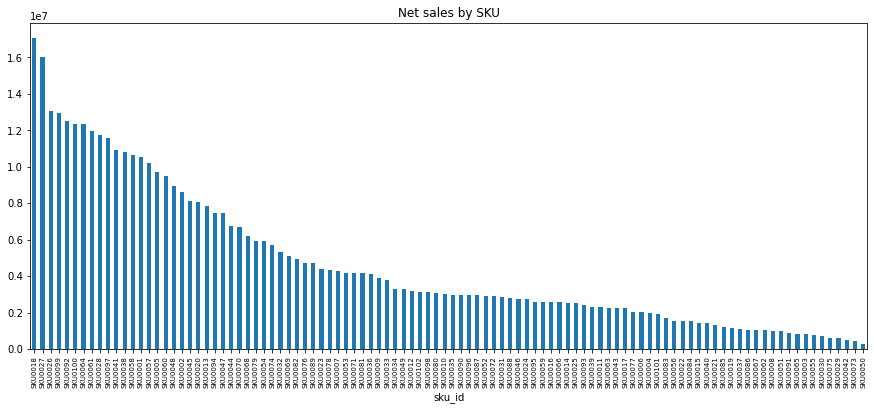

In [58]:
sku_sales_chart = sku_sales.plot(kind='bar', figsize=(15, 6), title='Net sales by SKU')
sku_sales_chart.tick_params(axis='x', which='major', labelsize = 7)

Как видим, график скошен вправо. 
Такое распределение характерно для розничных продаж, когда часть товаров приносят большую часть прибыли.

In [60]:
supplier_sales = fmcg_full.groupby(['supplier_id'])['net_sales'].sum().sort_values(ascending = False)

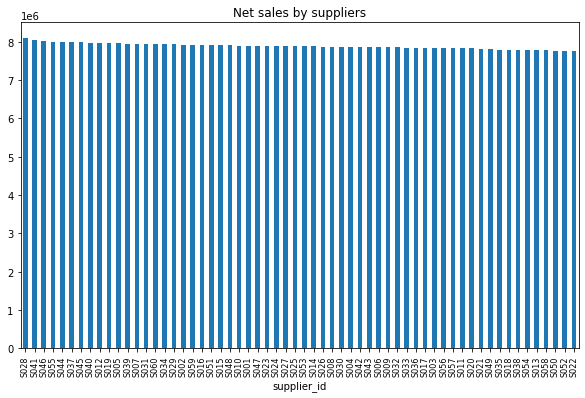

In [61]:
supplier_sales_chart = supplier_sales.plot(kind='bar', figsize=(10, 6), title='Net sales by suppliers')
supplier_sales_chart.tick_params(axis='x', which='major', labelsize = 8)

Распределение продаж между поставщиками равномерное, что нехарактерно для  розницы.
Часть поставщиков-лидеров обеспечивают обеспечивают наибольший товарооборот.

Создадим отдельную таблицу и в случайном порядке распределим артикулы по поставщикам.

In [77]:
suppliers_id = list(fmcg_full['supplier_id'].unique())
skus_id = list(fmcg_full['sku_id'].unique())

In [78]:
random_sku_supplier = {key: random.choice(suppliers_id) for key in skus_id}


In [79]:
fmcg_full['supplier_id_v2'] = fmcg_full['sku_id'].map(random_sku_supplier)

C:\Users\GoDar\AppData\Local\Temp\ipykernel_17268\738630054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fmcg_full['supplier_id_v2'] = fmcg_full['sku_id'].map(random_sku_supplier)


In [80]:
suppliers_sales_v2 = fmcg_full.groupby(['supplier_id_v2'])['net_sales'].sum().sort_values(ascending = False)

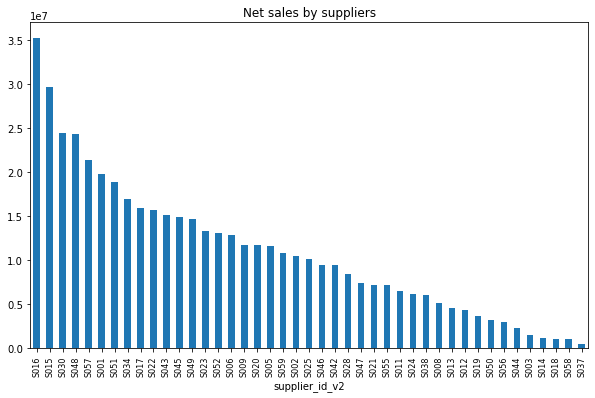

In [81]:
suppliers_sales_chart2 = suppliers_sales_v2.plot(kind='bar', figsize=(10, 6), title='Net sales by suppliers')
suppliers_sales_chart2.tick_params(axis='x', which='major', labelsize = 8)

Для дальнейшего построения модели данных будет использоваться схема "звезда". 
Поэтому разделим исходный датасет на таблицу фактов (orders) и 
таблицы измерений (stores, sku, suppliers, suppliers_contract_conditions)

In [82]:
orders = fmcg_full[['date', 'store_id', 'sku_id', 'units_sold', 'purchase_cost',
                    'list_price', 'discount_pct', 'supplier_id', 'lead_time_days']]

In [83]:
orders = orders.rename(columns = {'supplier_id_v2': 'supplier_id'})

In [84]:
orders.duplicated().sum() #строк-дублей нет

0

In [85]:
orders.head()

,date,store_id,sku_id,units_sold,purchase_cost,list_price,discount_pct,supplier_id,lead_time_days
0,2021-01-01,STORE0001,SKU0086,16,7.53,10.49,0.1,S008,11
1,2021-01-02,STORE0001,SKU0086,12,5.19,10.49,0.0,S057,6
2,2021-01-03,STORE0001,SKU0086,38,5.59,10.49,0.3,S017,6
3,2021-01-04,STORE0001,SKU0086,8,7.81,10.49,0.0,S012,7
4,2021-01-05,STORE0001,SKU0086,17,7.62,10.49,0.2,S038,8


In [86]:
orders['date'] = pd.to_datetime(orders['date'])

In [87]:
orders = orders[orders['date'] < '2023-10-01']

In [91]:
stores = fmcg_full[['store_id', 'country', 'city',
       'channel', 'latitude', 'longitude']]

In [92]:
stores = stores.drop_duplicates(subset = ['store_id'])

In [93]:
stores.head()

,store_id,country,city,channel,latitude,longitude
0,STORE0001,Germany,Berlin,Hypermarket,52.52586,13.39071
87600,STORE0002,Italy,Rome,Supermarket,41.94012,12.50588
175200,STORE0003,Italy,Milan,Supermarket,45.44037,9.20313
262800,STORE0004,Germany,Berlin,Hypermarket,52.50051,13.42074
350400,STORE0005,Poland,Warsaw,Hypermarket,52.25287,20.99579


In [119]:
sku = fmcg_full[['sku_id', 'sku_name', 'category',
       'subcategory']]

In [120]:
sku = sku.drop_duplicates(subset = ['sku_id'])

In [121]:
sku.head()

,sku_id,sku_name,category,subcategory
0,SKU0086,BrandB Shampoo,Personal Care,Shampoo
1095,SKU0016,BrandD Water,Beverages,Water
2190,SKU0049,BrandA Yogurt,Dairy,Yogurt
3285,SKU0036,BrandF Chocolate,Snacks,Chocolate
4380,SKU0006,BrandF Soda,Beverages,Soda


Обогатим данные, добавив наименования поставщиков из другого датасета (https://www.kaggle.com/datasets/salahuddinahmedshuvo/grocery-inventory-and-sales-dataset) 
и типы ("импорт", "дистрибьютор", "производитель").

In [100]:
suppliers_id_from_fmcg = fmcg_full['supplier_id']

In [101]:
suppliers_id_from_fmcg = suppliers_id_from_fmcg.drop_duplicates()

In [102]:
suppliers_id_from_fmcg.shape

(60,)

In [103]:
for_suppliers = pd.read_csv('Grocery_Inventory_and_Sales_Dataset.csv', delimiter = ',')

In [104]:
for_suppliers.head()

,Product_ID,Product_Name,Catagory,Supplier_ID,Supplier_Name,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Date_Received,Last_Order_Date,Expiration_Date,Warehouse_Location,Sales_Volume,Inventory_Turnover_Rate,Status
0,29-205-1132,Sushi Rice,Grains & Pulses,38-037-1699,Jaxnation,22,72,70,$4.50,8/16/2024,6/29/2024,9/19/2024,48 Del Sol Trail,32,19,Discontinued
1,40-681-9981,Arabica Coffee,Beverages,54-470-2479,Feedmix,45,77,2,$20.00,11/1/2024,5/29/2024,5/8/2024,36 3rd Place,85,1,Discontinued
2,06-955-3428,Black Rice,Grains & Pulses,54-031-2945,Vinder,30,38,83,$6.00,8/3/2024,6/10/2024,9/22/2024,3296 Walton Court,31,34,Backordered
3,71-594-6552,Long Grain Rice,Grains & Pulses,63-492-7603,Brightbean,12,59,62,$1.50,12/8/2024,2/19/2025,4/17/2024,3 Westerfield Crossing,95,99,Active
4,57-437-1828,Plum,Fruits & Vegetables,54-226-4308,Topicstorm,37,30,74,$4.00,7/3/2024,10/11/2024,10/5/2024,15068 Scoville Court,62,25,Backordered


In [105]:
suppliers_names = for_suppliers['Supplier_Name'].sample(n = 60, replace = 'False')

In [107]:
suppliers = pd.concat([suppliers_id_from_fmcg.reset_index(drop = True),suppliers_names.reset_index(drop = True)], axis = 1)

In [108]:
suppliers.head()

,supplier_id,Supplier_Name
0,S008,Linklinks
1,S057,Abata
2,S017,Fliptune
3,S012,Thoughtmix
4,S038,Voonyx


In [109]:
suppliers.rename(columns = {'Supplier_Name':'supplier_name'},inplace = True)

In [110]:
sup_types = ['distributor', 'manufacturer', 'importer']

In [111]:
suppliers['type'] = np.random.choice(sup_types, size=len(suppliers), p = [0.15,0.65,0.20])

In [112]:
suppliers['type'].value_counts()

manufacturer    44
importer        10
distributor      6
Name: type, dtype: int64

В таблицу sup_contract_conditions добавим столбец с уровнем вознаграждения, который поставщик платит ежемесячно
в % от достигнутого за месяц товарооборота (units_sold * purchase_cost * rebates).

In [113]:
sup_contract_conditions = suppliers['supplier_id']

In [114]:
rand_rebates = np.random.uniform(0.01, 0.05, size = len(sup_contract_conditions))
rebates = pd.Series(rand_rebates, name = 'rebates')
rebates = rebates.round(3)

In [115]:
sup_contract_conditions = pd.concat([sup_contract_conditions,rebates], axis = 1)

In [116]:
sup_contract_conditions.head()

,supplier_id,rebates
0,S008,0.042
1,S057,0.012
2,S017,0.032
3,S012,0.039
4,S038,0.026


In [117]:
orders.to_csv('orders.csv', index = False)
stores.to_csv('stores.csv', index = False)
sku.to_csv('sku.csv', index = False)
suppliers.to_csv('suppliers.csv', index = False)
sup_contract_conditions.to_csv('sup_contract_conditions.csv', index = False)